In [ ]:
import Control.Monad.Bayes.Class
import Control.Monad.Bayes.Sampler.Strict
import Control.Monad.Bayes.Weighted
import Control.Monad.Bayes.Enumerator
import Control.Monad
import Control.Arrow
import Numeric.Log
import qualified Data.Text as T

:l ../Plotting.hs

# Bayesian Models

Monad-Bayes exports a `Bayesian` datatype to make using Bayesian models easier. The idea is that you specify your model as a prior, generative model and a likelihood (separate from the generative model because you can't always get the density of a sample from a distribution).

Once you've done that, a number of standard operations, like obtaining the posterior or the posterior predictive, are automated for you.

Here's a simple example:

In [52]:
model :: MonadSample m => Bayesian m Bool Double
model = Bayesian {
    latent = bernoulli 0.5,
    generative = \x -> normal (if x then 2 else (-2)) 1,
    likelihood  = \x y -> normalPdf (if x then 2 else (-2)) 1 y
    }

Line 1: Use bimap
Found:
first (T.pack . show) . second (ln . exp)
Why not:
bimap (T.pack . show) (ln . exp)

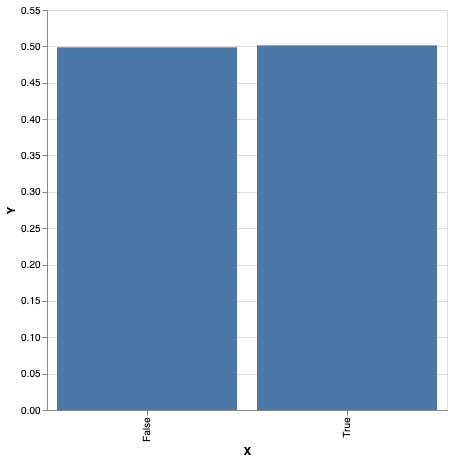

In [54]:
sampler $ plot . fmap (first (T.pack . show) . second (ln . exp)) . toEmpiricalWeighted <$> replicateM 100000 (weighted $ latent model)

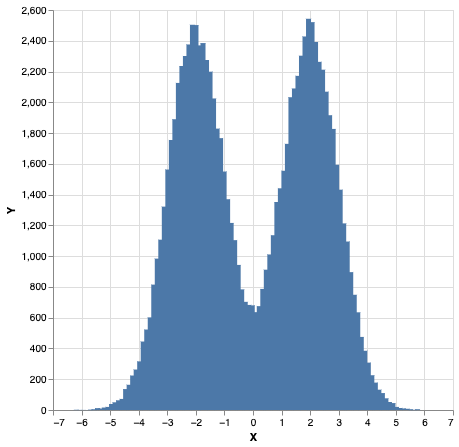

In [46]:
sampler $ plot . histogramToList . histogram 100 <$> replicateM 100000 (weighted $ priorPredictive model)

Line 1: Use bimap
Found:
first (T.pack . show) . second (ln . exp)
Why not:
bimap (T.pack . show) (ln . exp)

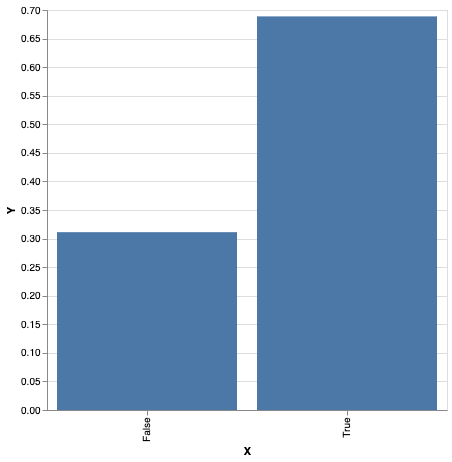

In [55]:
sampler $ plot . fmap (first (T.pack . show) . second (ln . exp)) . toEmpiricalWeighted <$> replicateM 100000 
    (weighted $ posterior model [0.1, 0.1])

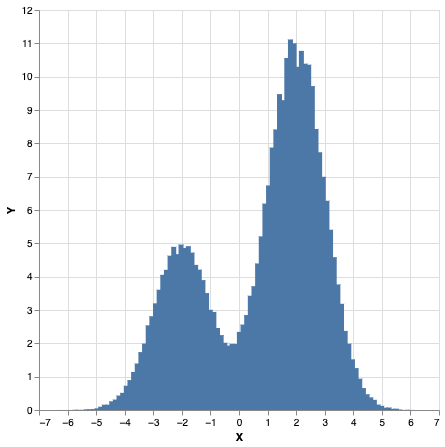

In [48]:
sampler $ plot . histogramToList . histogram 100 <$> replicateM 100000 (weighted $ posteriorPredictive model [0.1,0.1])

# Regression

And now an example with a regression:

In [69]:
:e BlockArguments 

range :: [Double]
range = [-10,-9.9..10] 


regression :: MonadSample m => Bayesian m (Double, Double, Double) [Double]
regression = Bayesian {
    latent = do 
            slope <- normal 0 2
            intercept <- normal 0 2
            noise <- gamma 4 4
            return (slope, intercept, noise),
    
    generative = \(slope, intercept, noise) -> do
            forM range \x -> normal (x*slope + intercept) (sqrt noise),
            
    likelihood = \(slope, intercept, noise) ys -> Prelude.sum [normalPdf (x*slope + intercept) (sqrt noise) y | (x,y) <- zip range ys] 
                
    }


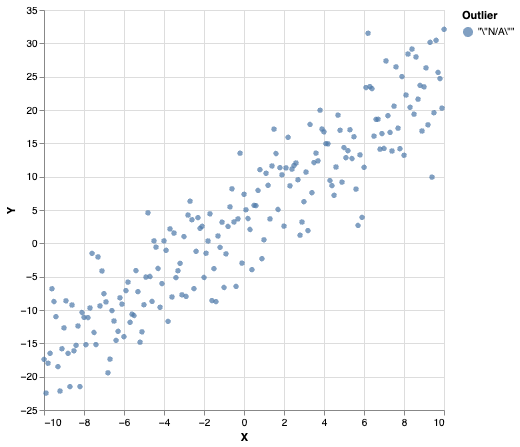

In [72]:
ys <- sampler $ priorPredictive regression

plot (fmap (second (T.pack . show)) (zip (zip range ys) (Prelude.repeat "N/A")))

In [ ]:
import Control.Monad.Bayes.Inference.MCMC

ys <- sampler $ mcmc MCMCConfig {numMCMCSteps = 5000, numBurnIn = 25, proposal = SingleSiteMH} 
    $ posteriorPredictive regression [take 200 $ repeat 1]


In [ ]:
plot (fmap (second (T.pack . show)) (zip (zip range $ ys !! 0) (Prelude.repeat "N/A")))